## Modified introduction using forex data

This is the trading rule example shown in [the introduction](https://github.com/robcarver17/pysystemtrade/blob/master/docs/introduction.md) but modified to use Interactive Brokers instead of CSV files as data source.  

IB requires a minimum equity and a monthly subscription to provide historical data on future contracts.  This example was modified to use FX prices instead futures to make it runnable with free unfunded paper trading accounts.  Note that Rob [does not recommend trading FX spot data with IB due to their high fees](https://github.com/robcarver17/pysystemtrade/issues/517#issuecomment-1010770678).

First, import the required packages and initialize ib_insync.  

In [1]:
from sysbrokers.IB.ib_connection import connectionIB
from sysbrokers.IB.ib_Fx_prices_data import ibFxPricesData

from ib_insync import util
util.startLoop() #only required when running inside a notebook

Connecting to Interactive Brokers gateway...

In [2]:
conn = connectionIB(111)
conn

IB broker connection{'ipaddress': 'localhost', 'port': 4001, 'client': 111}

See what fx instruments we have configured.  These are configured in `sysbrokers/IB/ib_config_spot_FX.csv`

In [3]:
ibfxpricedata = ibFxPricesData(conn)
ibfxpricedata.get_list_of_fxcodes()

['AUDUSD',
 'CADUSD',
 'CHFUSD',
 'EURUSD',
 'GBPUSD',
 'HKDUSD',
 'JPYUSD',
 'KRWUSD',
 'CNHUSD',
 'SGDUSD']

Now we select one instrument (`EURUSD`) and try to fetch historical data for it.

In [4]:
ibfxpricedata.get_fx_prices('EURUSD')

index
2021-11-18 23:00:00    1.13710
2021-11-19 23:00:00    1.12815
2021-11-22 23:00:00    1.12370
2021-11-23 23:00:00    1.12485
2021-11-24 23:00:00    1.12005
                        ...   
2022-11-11 23:00:00    1.03445
2022-11-14 23:00:00    1.03270
2022-11-15 23:00:00    1.03495
2022-11-16 23:00:00    1.03950
2022-11-17 23:00:00    1.03290
Name: FINAL, Length: 261, dtype: float64

Data can also be indexed as a python dict:

In [5]:
ibfxpricedata['JPYUSD']

index
2021-11-18 23:00:00    0.008752
2021-11-19 23:00:00    0.008772
2021-11-22 23:00:00    0.008705
2021-11-23 23:00:00    0.008685
2021-11-24 23:00:00    0.008663
                         ...   
2022-11-11 23:00:00    0.007205
2022-11-14 23:00:00    0.007147
2022-11-15 23:00:00    0.007180
2022-11-16 23:00:00    0.007167
2022-11-17 23:00:00    0.007109
Name: FINAL, Length: 261, dtype: float64

Create the trading rule

In [6]:
import pandas as pd
from sysquant.estimators.vol import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds Lfast, Lslow and vol_lookback

    """
    if Lslow is None:
        Lslow = 4 * Lfast

    ## We don't need to calculate the decay parameter, just use the span directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma

    vol = robust_vol_calc(price.diff())

    return raw_ewmac / vol

Run a forecast with the previous rule

In [7]:
price=ibfxpricedata['EURUSD']
ewmac=calc_ewmac_forecast(price, 32, 128)
ewmac.tail(5)

index
2022-11-11 23:00:00   -2.062827
2022-11-14 23:00:00   -1.893241
2022-11-15 23:00:00   -1.727576
2022-11-16 23:00:00   -1.539589
2022-11-17 23:00:00   -1.355229
Name: FINAL, dtype: float64

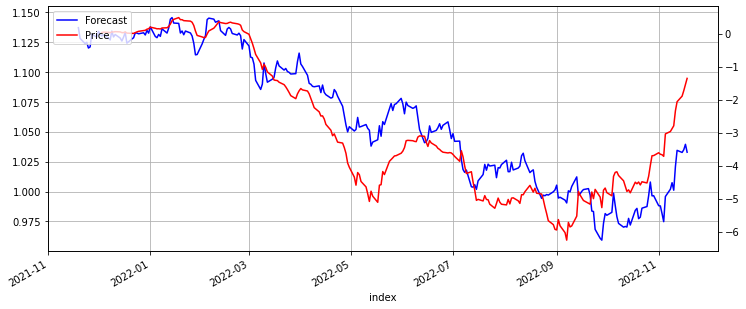

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

ax1 = price.plot(color='blue', grid=True, label='Forecast')
ax2 = ewmac.plot(color='red', grid=True, secondary_y=True, label='Price')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

The original introduction jumps directly to "Did we make any money?".  
I would like to see here the orders that were triggered by this forecast, but instead we jump directly into P&L.  Still, these are the P&L numbers for this forecast and data:

In [9]:
from systems.accounts.account_forecast import pandl_for_instrument_forecast
account = pandl_for_instrument_forecast(forecast = ewmac, price = price)
account.percent.stats()

[[('min', '-1.11'),
  ('max', '1.595'),
  ('median', '-0.002786'),
  ('mean', '0.01743'),
  ('std', '0.3855'),
  ('skew', '0.2911'),
  ('ann_mean', '4.239'),
  ('ann_std', '6.167'),
  ('sharpe', '0.6873'),
  ('sortino', '0.9614'),
  ('avg_drawdown', '-0.8879'),
  ('time_in_drawdown', '0.8831'),
  ('calmar', '0.9932'),
  ('avg_return_to_drawdown', '4.774'),
  ('avg_loss', '-0.2215'),
  ('avg_gain', '0.2722'),
  ('gaintolossratio', '1.229'),
  ('profitfactor', '1.152'),
  ('hitrate', '0.4839'),
  ('t_stat', '0.712'),
  ('p_value', '0.4772')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

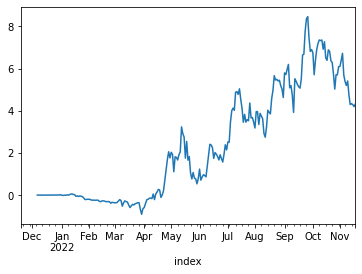

In [10]:
account.curve().plot()
plt.show()

In [11]:
conn.close_connection()